# Preparation of the bathymetry, topography, coast_line files needed to create the FEMTIC mesh

MMT synthetic example in the Mariana Trench to illustrate a MMT survey. Mesh with almost no padding

In [29]:
import sys
sys.path.append('../../src')
import femticPy

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Set up DataGen object
 
 First a femticpy.DataGen object has to be created to load the MT data and coordinates

In [31]:
# the file will be written in the input_data directory
mmt_inv = femticPy.DataGen(survey = 'mmt', outdir = './input_data')

In [32]:
# Loading the data and the data coordinates
mmt_inv.read_MTdata('./input_data/edi_files/')
mmt_inv.read_MTdata_coordinates('./input_data', 'coords_MT.csv')

Read 15 .edi files


/Users/sei029/Documents/projects/strategic_FEMTIC/repo_github/femticpy/src/femticPy.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Z.drop(masked, inplace=True)
/Users/sei029/Documents/projects/strategic_FEMTIC/repo_github/femticpy/src/femticPy.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_VTF.drop(masked, inplace=True)
/Users/sei029/Documents/projects/strategic_FEMTIC/repo_github/femticpy/src/femticPy.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [33]:
mmt_inv.mt_coords_utm

,id,east,north,z
0,01,600.0,1300.0,5.06143
1,02,600.0,1270.0,7.37934
2,03,600.0,1240.0,9.26227
3,04,600.0,1210.0,6.60975
4,05,600.0,1180.0,4.94718
5,06,620.0,1300.0,5.71539
6,07,620.0,1270.0,7.41213
7,08,620.0,1240.0,9.49203
8,09,620.0,1210.0,6.37154
9,10,620.0,1180.0,4.98219


In [34]:
# we center the data to a anchor point (center of the data set) which will also be the center of the future mesh
mmt_inv.center_data()
mmt_inv.anchor

[1240.0, 620.0]

In [35]:
# we can check the coordinates in utm format (original) or respect to the future mesh
mmt_inv.mt_coords_utm  # real world coordinates
mmt_inv.mt_coords      # in mesh coordinates

,id,east,north,z
0,01,-20.0,60.0,5.06143
1,02,-20.0,30.0,7.37934
2,03,-20.0,0.0,9.26227
3,04,-20.0,-30.0,6.60975
4,05,-20.0,-60.0,4.94718
5,06,0.0,60.0,5.71539
6,07,0.0,30.0,7.41213
7,08,0.0,0.0,9.49203
8,09,0.0,-30.0,6.37154
9,10,0.0,-60.0,4.98219


In [36]:
# we define the analysis domain, the extent of the total mesh including padding
# the DEM used needs to cover beyond the analysis domain
mmt_inv.analysis_domain = [[-150.0, 150.0],
                                [-150.0, 150.0],
                                [-150.0, 150.0]]   

 ## 2. Prepare the files

In [37]:
# DEM file downloaded from   https://www.ncei.noaa.gov/maps/grid-extract/  as   ETOPO2022 Bedrock 60 sec
# The bedrock .TIFF file contains elevations, which can be converted to .xyz file in QGIS (using gdal2xyz)
# 

In [38]:
dem_file = './input_data/dem.xyz'
dem_geo = pd.read_csv(dem_file,  names=['Longitude','Latitude','z'] )

In [39]:
# transform geographical coordinates into utm using pyproj
def deg2utm(df,zone,south=True):
    from pyproj import Proj
    p = Proj(proj='utm', ellps='WGS84', zone=zone, south=south)
    lat_UTM = []
    long_UTM = []
    for i in range(len(df)):
        lat,lon = p(df['Longitude'][i],df['Latitude'][i])
        long_UTM.append(lon)
        lat_UTM.append(lat)
    df['east'] = np.array(lat_UTM) / 1000
    df['north'] = np.array(long_UTM) /1000
    return df


In [40]:
UTM_zone = 54
dem = deg2utm(dem_geo, zone=UTM_zone, south=False)
dem.shape

(32208, 5)

In [41]:
#The DEM is a bit large we resample it every 5 pts 
ptx = pd.unique(dem['east'])[::1]
pty = pd.unique(dem['north'])[::1]
ny = len(pty)
nx = len(ptx)

dem_sp = dem[dem['east'].isin(ptx)]
dem_sp = dem_sp[dem_sp['north'].isin(pty)]

dem_sp.reset_index(inplace=True)

dem = dem_sp
dem.shape

(32208, 6)

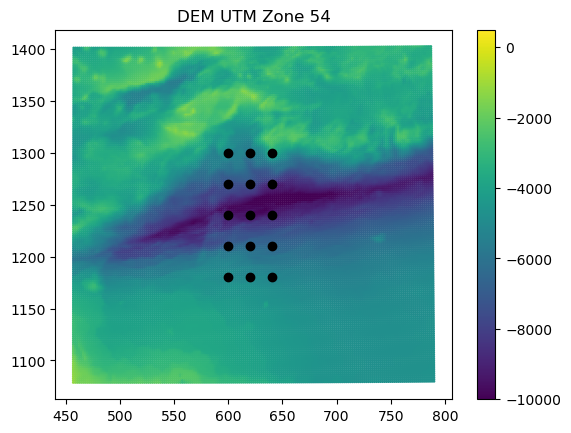

In [42]:
#plot the DEM along with the stations to check if all is in order
cb  = plt.scatter(dem['east'], dem['north'], c=dem['z'], vmin = -10000, vmax = 500,s=1)
plt.plot(mmt_inv.mt_coords_utm['east'], mmt_inv.mt_coords_utm['north'], 'ko')
plt.title('DEM UTM Zone %d'%UTM_zone)
plt.colorbar(cb)

Text(0.5, 1.0, 'DEM mesh coordinate system')

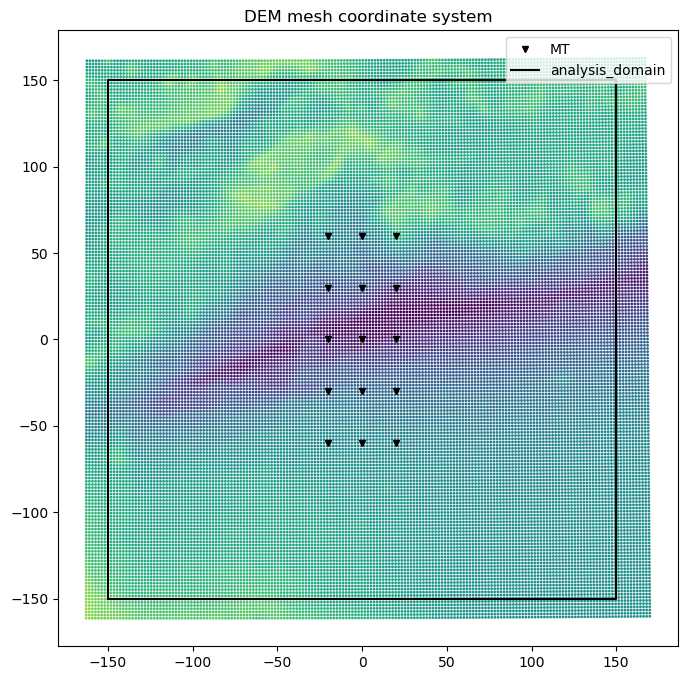

In [43]:
# Center the DEM to the mesh coordinates and plot to check if all is ok
dem['north'] -= mmt_inv.anchor[0]
dem['east']  -= mmt_inv.anchor[1]

mmt_inv.plot_data_loc(plot_ids = False)
plt.scatter(dem['east'], dem['north'], c=dem['z'], vmin = -10000, vmax = 500,s=1)
plt.title('DEM mesh coordinate system')

## 2.1 Create the coast line file

### 2.1.1 Extract coast from DEM file

There is no coast line for this example

Because there is no land area in the computational domain, please set
[Number of boundaries] to zero. 

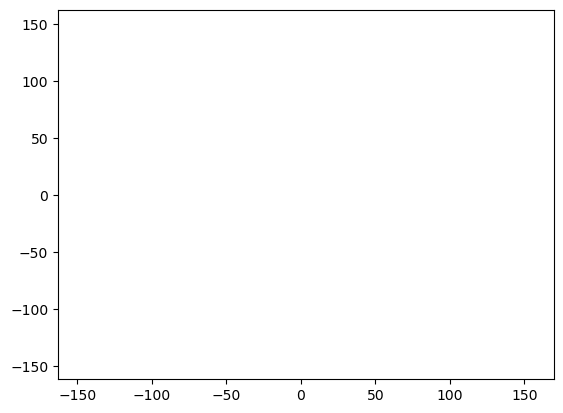

In [16]:
# using the tricontour function we can extract the 0m elevation contour, the coasts
CS = plt.tricontour(dem['east'][::1],dem['north'][::1],dem['z'][::1], [0])

There is no 0m boundaries 



In [17]:
def write_coast_file(outdir):
    file_loc = os.path.join(outdir, 'coast_line.dat') 
    file = open(file_loc,'w') 
    file.write('0')
    file.close() 

(-165.0, 165.0, -165.0, 165.0)

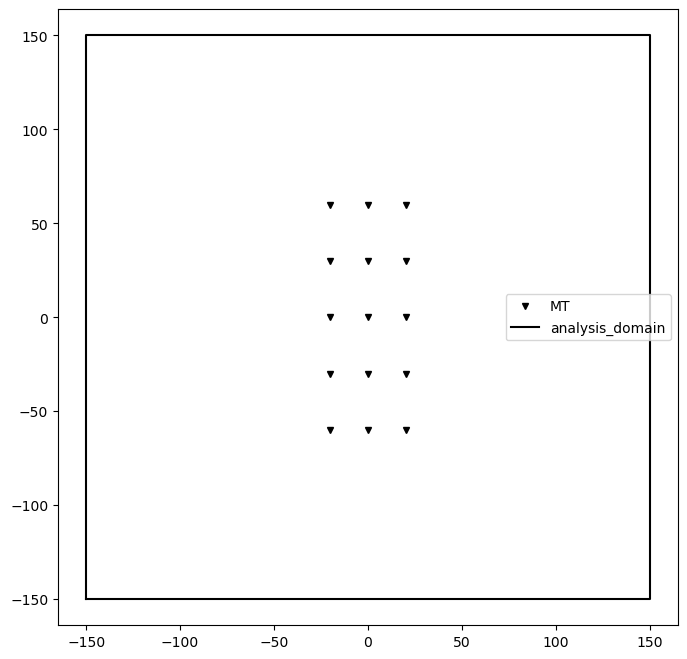

In [18]:
# write the file and plot the MT data
mmt_inv.plot_data_loc(plot_ids = False)
write_coast_file(outdir='./input_data')
plt.axis('equal') 
#plt.xlim(-200,-100)
#plt.ylim(-200,-100)

In [19]:
#auslamp_inv.plot_data_loc(plot_ids = True)   # ERROR: TO CHECK

## 2.2 Create topo and bathy files
* Both files contains coordinates of the complete DEM
* The bathy file has positive values for negative elevations, and positive elevations are set to -1m
* The topo file has positive values for positive elevations, and negative elevations are set to -1m
* Check FEMTIC docs for details

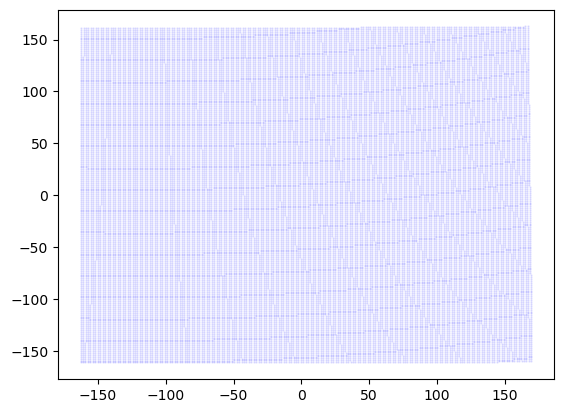

In [20]:
plt.scatter(dem['east'][dem['z']>0], dem['north'][dem['z']>0],c='r',s=0.5, alpha=0.1)
plt.scatter(dem['east'][dem['z']<0], dem['north'][dem['z']<0],c='b',s=0.5, alpha=0.1)

In [21]:
# we extract the dem from the dataframe to work with it
dem_z = np.array(dem['z'])
dem_z

array([-4105.19, -4189.  , -4247.87, ..., -4708.19, -4709.38, -4694.31])

In [22]:
bathy_data = -np.where(dem_z > 0, 1, dem_z)
topo_data = np.where(dem_z < 0, -1, dem_z)

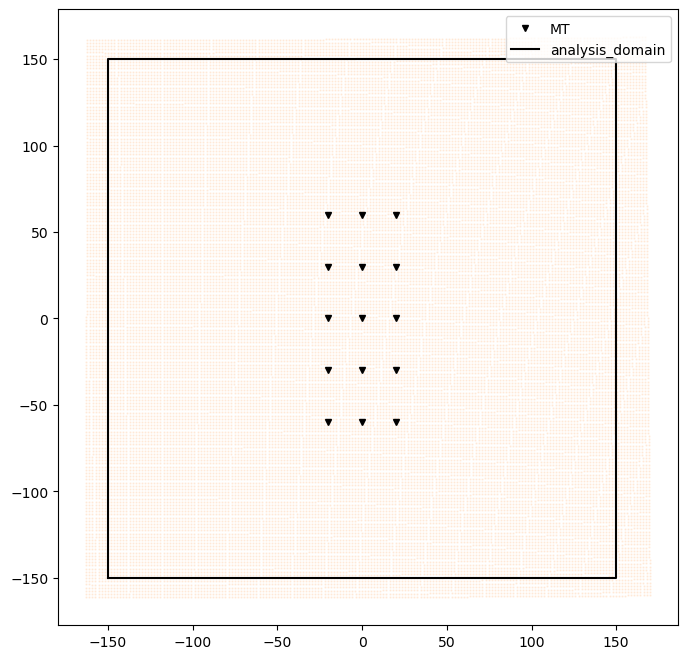

In [23]:
# we plot MT data and inversion domain, topo/bathy and the coast line
mmt_inv.plot_data_loc(plot_ids = False)
plt.scatter(dem['east'][topo_data>0], dem['north'][topo_data>0],s=0.5, alpha=0.1)
plt.scatter(dem['east'][bathy_data>0], dem['north'][bathy_data>0],s=0.5, alpha=0.1)


In [24]:
#The files are written in km

def write_topo_file(dem, topo_data, outdir):
        file_loc = os.path.join(outdir, 'topography.dat') 
        file = open(file_loc,'w') 
        for i in range(len(dem)):
            file.write('%4.3f %4.3f %4.3f\n'%(dem['north'][i], dem['east'][i], topo_data[i]/1000))
        file.close() 

def write_bathy_file(dem, bathy_data, outdir):
        file_loc = os.path.join(outdir, 'bathymetry.dat') 
        file = open(file_loc,'w') 
        for i in range(len(dem)):
            file.write('%4.3f %4.3f %4.3f\n'%(dem['north'][i], dem['east'][i], bathy_data[i]/1000))
        file.close() 


In [25]:
write_topo_file(dem,  topo_data,  outdir='./input_data')
write_bathy_file(dem, bathy_data, outdir='./input_data')

## 2.3  Modify elevation of the MT sites to match the topography

In order to have the ellipses closely centered on the earth surface. If there are (larges) differences between the MT data elevation and the DEM the ellipses will be hanging in the air (or water) a bit or b benaeth the surface, which will cause the smaller cells close to the site to not be centered, and some high resolution might be lost.

We use a kdtree to align elevation of mt site with topo (closest elevation will be assigned)

In [26]:
from scipy.spatial import KDTree
tree = KDTree(np.c_[dem['east'],dem['north']])
dd, ii = tree.query(np.c_[mmt_inv.mt_coords['east'].values, mmt_inv.mt_coords['north'].values], k=1)
mt_elev = dem['z'][ii].values

In [27]:
# rewrite mt_coords:
mmt_inv.mt_coords_utm['z'] =  mt_elev / 1000
outdir_coords = './input_data/coords_MT.csv'

# WARNING: this will overwrite the original coordinate file 
mmt_inv.mt_coords_utm.to_csv(outdir_coords,index=False,header=False, sep= '\t')